In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, smooth, tangential_velocity, robust_smooth



#### Drfiter Data

In [2]:
from datetime import datetime
import netCDF4 as nc

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)

drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


In [3]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []

rho2s = []
Qrs = []
vts = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc_esp, yc_esp, w_esp, Q_esp, Rc_esp, psi0_esp, A_esp = espra(xi, yi, ui, vi, plot_flag=False, A_flag=True) 
    w_esp /= deg_to_m(np.mean(yi))
    q11_esp, q12_esp, q22_esp = Q_esp[0,0], Q_esp[1,0], Q_esp[1,1]

    results.append(dict(xc=xc_esp, yc=yc_esp, w=w_esp,
                        q11=q11_esp, q12=q12_esp, q22=q22_esp,
                        Rc=Rc_esp, psi0=psi0_esp, A=A_esp, n=len(xi), Time=t))

    dx, dy = xi - xc_esp, yi - yc_esp
    rho2s.extend(q11_esp*dx**2 + 2*q12_esp*dx*dy + q22_esp*dy**2)
    Qrs.extend(np.sqrt((q11_esp*dx + q12_esp*dy)**2 + (q12_esp*dx + q22_esp*dy)**2))
    vts.extend(np.abs(tangential_velocity(xi, yi, ui, vi, xc_esp, yc_esp,
                                np.array([[q11_esp, q12_esp],[q12_esp, q22_esp]]))))

df_results = pd.DataFrame(results)
As = np.repeat(df_results.A, df_results.n)
df_results['sA'], _ , _ = robust_smooth(np.arange(len(df_results)), df_results.A)
sAs = np.repeat(df_results.sA, df_results.n)
df_Rc_info = pd.DataFrame({'rho2': rho2s, '|Qr|': Qrs, 'vt': vts, 'A': As, 'sA': sAs})
df_Rc_info = df_Rc_info.reset_index(drop=True)
df_results


,xc,yc,w,q11,q12,q22,Rc,psi0,A,n,Time,sA
0,154.267637,-37.953826,-1.835220e-07,1.130276,-0.102656,0.894063,0.646719,0.002689,-0.006429,9,2023-10-20 12:00:00,-0.006745
1,154.321904,-37.919899,-2.089448e-07,1.180300,-0.046509,0.849075,0.562943,0.002311,-0.007291,9,2023-10-21 12:00:00,-0.006953
2,154.235778,-37.942048,-2.148768e-07,0.939455,0.051388,1.067258,0.590595,0.002643,-0.007576,13,2023-10-22 12:00:00,-0.007151
3,154.169484,-37.965548,-2.316670e-07,0.909202,0.121553,1.116116,0.527249,0.002251,-0.008097,17,2023-10-23 12:00:00,-0.007339
4,154.153028,-37.911515,-2.248849e-07,0.952993,-0.044465,1.051401,0.547484,0.002382,-0.007947,18,2023-10-24 12:00:00,-0.007519
...,...,...,...,...,...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-2.496089e-07,1.031158,-0.250171,1.030478,0.457939,0.001804,-0.008604,18,2024-02-04 12:00:00,-0.009277
108,150.654736,-37.237212,-2.727406e-07,0.852219,-0.275944,1.262756,0.424913,0.001654,-0.009160,18,2024-02-05 12:00:00,-0.009455
109,150.705005,-37.318210,-2.489821e-07,0.640753,0.184493,1.613785,0.285161,0.000638,-0.007848,18,2024-02-06 12:00:00,-0.009642
110,150.685157,-37.294499,-3.073088e-07,0.556426,0.259359,1.918075,0.319506,0.000901,-0.008825,18,2024-02-07 12:00:00,-0.009838


,rho2,|Qr|,vt,A,sA
0,0.196975,0.470538,0.006039,-0.006429,-0.006745
1,0.172582,0.423164,0.005732,-0.006429,-0.006745
2,0.175694,0.407742,0.004936,-0.006429,-0.006745
3,0.166877,0.382518,0.004982,-0.006429,-0.006745
4,0.169678,0.381375,0.004981,-0.006429,-0.006745
...,...,...,...,...,...
1987,0.030920,0.243700,0.004765,-0.008777,-0.010045
1988,0.024074,0.219834,0.004056,-0.008777,-0.010045
1989,0.023224,0.188079,0.003253,-0.008777,-0.010045
1990,0.027800,0.173541,0.002212,-0.008777,-0.010045


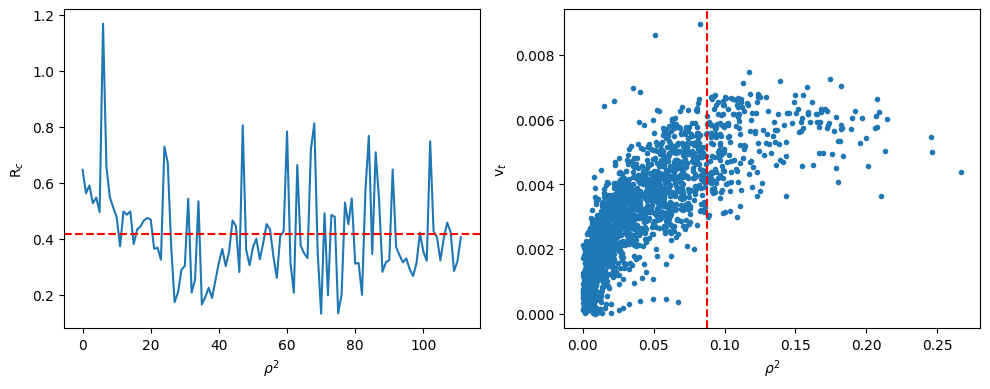

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(df_results.Rc)
Rc_mean = df_results.Rc.mean()
axs[0].axhline(y=Rc_mean, color='r', ls='--')
axs[0].set_xlabel(r'$\rho^2$')
axs[0].set_ylabel(r'R$_c$')

axs[1].scatter(df_Rc_info.rho2, df_Rc_info.vt, marker='.')
axs[1].axvline(x=Rc_mean**2/2, color='r', ls='--')
# axs[1].axvline(x=Rc_opt**2/2, color='g', ls='--')
axs[1].set_xlabel(r'$\rho^2$')
axs[1].set_ylabel(r'v$_t$')

plt.tight_layout()
df_Rc_info


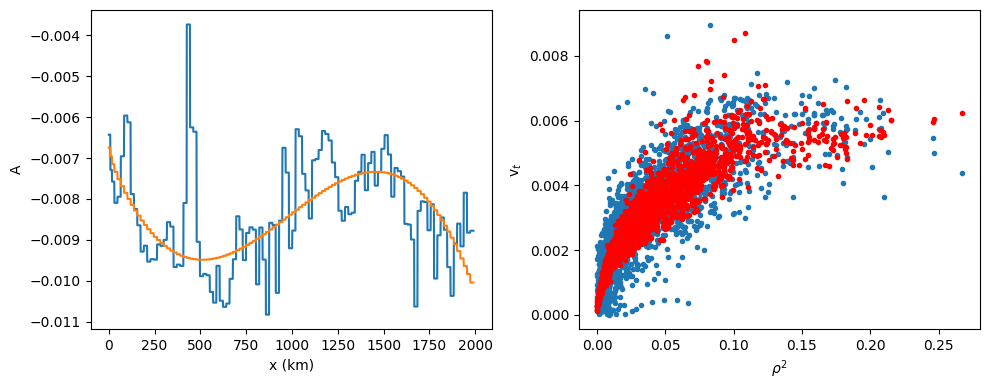

In [5]:
A_mean = df_results.A.mean()

from scipy.optimize import minimize_scalar

A = df_Rc_info.sA #A_mean
rho2 = df_Rc_info.rho2            
Qr   = df_Rc_info['|Qr|']     
vt   = df_Rc_info.vt

def loss(Rc):
    vt_theo = 2 * np.abs(A) * np.exp(-rho2 / Rc**2) * Qr
    return np.sum((vt - vt_theo)**2)

res = minimize_scalar(loss, bounds=(1e-3, 1e3), method='bounded')
Rc_opt = res.x

psi0_opt = - df_results.sA * Rc_opt**2

df_results['Rc_opt'] = Rc_opt
df_results['psi0_opt'] = psi0_opt

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(df_Rc_info.A)
axs[0].plot(df_Rc_info.sA)
# axs[0].axhline(y=A_mean, color='r', ls='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('A')

axs[1].scatter(df_Rc_info.rho2, df_Rc_info.vt, marker='.')
vt_theo = 2 * np.abs(A) * np.exp(-rho2 / Rc_opt**2) * Qr
axs[1].scatter(df_Rc_info.rho2, vt_theo, color='r', marker='.')
axs[1].set_xlabel(r'$\rho^2$')
axs[1].set_ylabel(r'v$_t$')

plt.tight_layout()


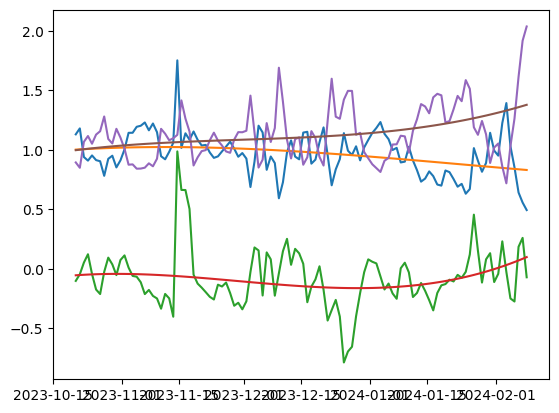

In [6]:
df_results['sq11'], _ , _ = robust_smooth(np.arange(len(df_results)), df_results.q11)
df_results['sq12'], _ , _ = robust_smooth(np.arange(len(df_results)), df_results.q12)
df_results['sq22'], _ , _ = robust_smooth(np.arange(len(df_results)), df_results.q22)

plt.plot(df_results.Time, df_results.q11)
plt.plot(df_results.Time, df_results.sq11)
plt.plot(df_results.Time, df_results.q12)
plt.plot(df_results.Time, df_results.sq12)
plt.plot(df_results.Time, df_results.q22)
plt.plot(df_results.Time, df_results.sq22)


In [7]:
lon = np.linspace(150, 155.5, 100)
lat = np.linspace(-39, -36, 50)
Lon, Lat = np.meshgrid(lon, lat)

U = np.zeros((Lon.shape[0], Lon.shape[1], len(df_results)))
V = np.zeros((Lon.shape[0], Lon.shape[1], len(df_results)))
RHO2 = np.zeros((Lon.shape[0], Lon.shape[1], len(df_results)))

for k in range(len(df_results)):
    data = df_results.iloc[k]
    
    dx, dy = Lon - data.xc, Lat - data.yc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    RHO2[:,:,k] = rho2
    U[:,:,k] = - data.sA * np.exp( - rho2 / data.Rc_opt**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy ) 
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.Rc_opt**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 
    


(np.float64(150.0), np.float64(155.5), np.float64(-39.0), np.float64(-36.0))

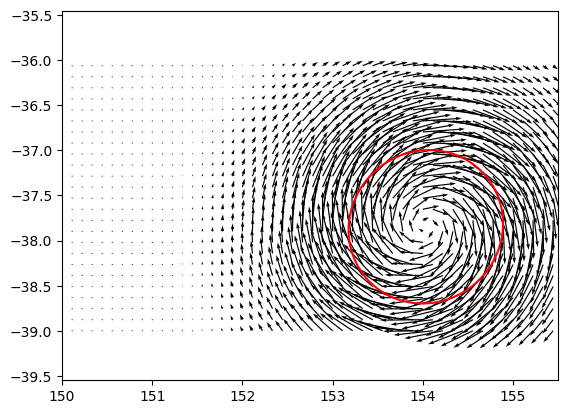

In [13]:
k = 10
spac = 2
plt.quiver(Lon[::spac,::spac], Lat[::spac,::spac],
           U[::spac,::spac,k], V[::spac,::spac,k], scale=)
plt.contour(Lon, Lat, RHO2[:,:,k], levels=[Rc_opt**2/2], colors='r')
plt.axis('equal')



In [17]:
V.max()

np.float64(0.010042741750241654)

In [9]:
Rc_opt

np.float64(1.2215726429887668)